# Homework 1

### CS328 — Numerical Methods for Visual Computing
- - -

**Out** on Wednesday 28.9, **due** on Wednesday 12.10 (before class).

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text. Please use the same format when submitting your answers. Begin your response to each problem with a <tt>&nbsp;<b>## Solution</b>&nbsp;&nbsp;</tt> markdown cell. Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use <a href="https://www.continuum.io/downloads">Anaconda 4</a>, specifically the version based on Python 3.5.

<br><div class="alert alert-warning">
Please keep in mind that homework assignments must be done individually.
</div>

### Prelude

The following fragment imports ``time`` (for benchmarking) along with NumPy and Matplotlib and configures the latter to produce nice graphics even on recent high-resolution screens. The import statements at the end establish a shorthand notation for the most common integer and floating point formats.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import time
import numpy as np
from matplotlib import pyplot as plt

from numpy import uint16 as u16
from numpy import uint32 as u32
from numpy import uint64 as u64

from numpy import float16 as f16
from numpy import float32 as f32
from numpy import float64 as f64

When doing the exercises below, please pay attention to the fact that NumPy will often conservatively upgrade the representation of number types in arithmetic operations when the input argument types don't match. This may not be intended and give "too accurate" results—to ensure that computations are performed at the desired precision, all operands must be given using a consistent type.

In [2]:
print(type(f32(1) + 1.0))      # oops, 64 bit output (default Python floats use double precision)
print(type(f32(1) + f32(1.0))) # likely this was the intended behavior
print(type(u32(1) + 2))        # oops, '2' is interpreted as a 64 bit integer
print(type(u32(1) + u32(2)))   # intended behavior

<class 'numpy.float64'>
<class 'numpy.float32'>
<class 'numpy.int64'>
<class 'numpy.uint32'>


We'll also have to fix something: the NumPy square root function ``np.sqrt()`` can change the data type (``dtype``) of the input array in certain situations, so we'll define an alternative version to be used in this homework that does not have this behavior.

In [3]:
def sqrt(x):
    x = np.array(x)
    return np.sqrt(x, dtype=x.dtype)

Finally, two more definitions: the helper functions ``f2i`` and ``i2f``  below reinterpret floating point values as an integers and vice versa. We'll use these in Problem 1 to access the bit-level representation of an IEEE 754 floating point value.

In [4]:
def f2i(value):
   return value.view('u%i' % value.itemsize)

def i2f(value):
   return value.view('f%i' % value.itemsize)

## Problem 1: Warmup: ULPs and Absolute Error (10+10 points)
-- --

The bit-level layout of IEEE754 floating point values is specially designed such that contiguous ranges of positive (or negative) floating point numbers are also contiguous when re-interpreted as integers. Use this property along with the functions ``f2i`` and ``i2f`` and the aliases ``f16`` etc. defined above to answer the following questions:

1. How many floating point values are located between the values ``1`` and ``2``, including the endpoints? How about ``1001`` and ``1002`` ? Give answers for 16, 32, and 64 bit precision variants. <br><br>

2. How large is 1 ULP for the value constant $\pi$ expressed in 64 bit arithmetic? Suppose that we use this value to compute the surface area of the earth given its radius of $\approx 6.353\cdot 10^6m$. Assuming that the earth is perfectly spherical, and that the discretization of $\pi$ is the only source of error in this computation, specify the absolute error in square meters.

## Solution

In [15]:
print("1.\n The number of values between 1 and 2 in f16 notation is", (f2i(f16(2)) - f2i(f16(1))+1))
print("The number of values between 1001 and 1002 in f16 notation is",(f2i(f16(1002)) - f2i(f16(1001))+1))
print("The number of values between 1 and 2 in f32 notation is", (f2i(f32(2)) - f2i(f32(1))+1))
print("The number of values between 1001 and 1002 in f32 notation is",(f2i(f32(1002)) - f2i(f32(1001))+1))
print("The number of values between 1 and 2 in f64 notation is", (f2i(f64(2)) - f2i(f64(1))+1))
print("The number of values between 1001 and 1002 in f64 notation is",(f2i(f64(1002)) - f2i(f64(1001))+1))

1.
 The number of values between 1 and 2 in f16 notation is 1025
The number of values between 1001 and 1002 in f16 notation is 3
The number of values between 1 and 2 in f32 notation is 8388609
The number of values between 1001 and 1002 in f32 notation is 16385
The number of values between 1 and 2 in f64 notation is 4.50359962737e+15
The number of values between 1001 and 1002 in f64 notation is 8.79609302221e+12


In [18]:
print("2.\nThe ULP of PI is ")
oneAfterPI = i2f(f2i(f64(np.pi)) + u64(1))
ulp = oneAfterPI - np.pi
print(ulp)

def surface(pi) :
    return f64(4)*pi*np.power(f64(6.353)*np.power(10, 6.0), 2.0)

print("The error is : ", surface(oneAfterPI) -surface(np.pi))

2.
The ULP of PI is 
4.4408920985e-16
The error is :  0.0625


## Problem 2: Series Approximations, Forward/Backward Error (10 + 10 + 10)
-- --
Consider the power series representation of the sine function, which is defined as

$$
\sin(x)=x-\frac{x^3}{3!}+\frac{x^5}{5!}-\frac{x^7}{7!}+\cdots
$$

1. What are the *relative* forward and backward errors when we approximate this function by its first two series terms? Provide results for $x=2^x$ where $x\in[-1, 0, 1]$.

  What trend do you observe? Plot the two functions in the same graph and justify your observation.<br><br>

2. The relative condition number of a function $f(x)$ at position $x$ is defined as
$$
\frac{\left|f(x+\delta x)-f(x)\right|}{\left|f(x)\right|} \big/ \frac{\left|\delta x\right|}{\left|x\right|}.
$$
  Assuming that the input to our sine approximation is already contaminated with numerical errors, use the above definition to decide where (i.e. at which of the three positions analyzed above) the output is least affected by additional errors introduced by the approximation.<br><br>

3. List three different kinds of numerical problems that can arise when evaluating the above power series with very many terms (e.g. thousands), and what parts of the expression specifically cause them.<br><br>

4. For what argument ranges is evaluating the sine function numerically sensitive? (In the sense that small perturbations of the input mantissa can lead to large changes in the computed result). Why is this the case?

## Solution

1

The relative forward error for 0.500000 is : 0.000540
The relative backward error for 0.500000 is : 0.000590
The relative forward error for 1.000000 is : 0.009671
The relative backward error for 1.000000 is : 0.014889
The relative forward error for 2.000000 is : 0.266833
The relative backward error for 2.000000 is : 0.635136
We observe that the forward and backward error tend to grow as the x grows.
We also see in the plot that the two curve diverge as x grow.


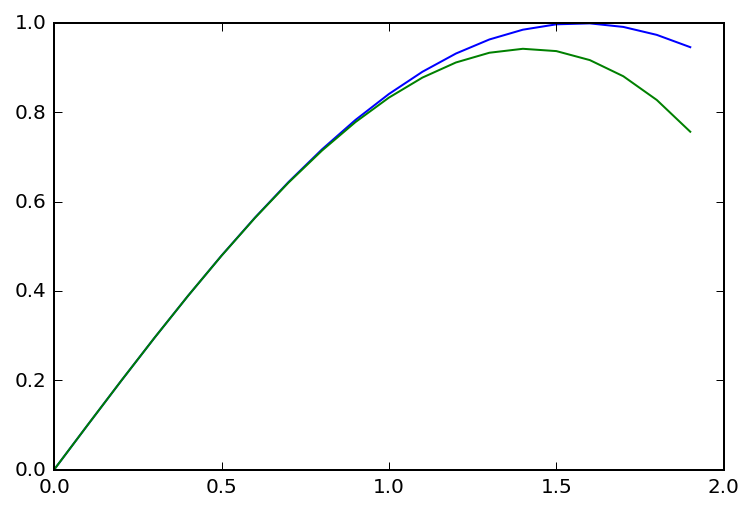

2.
The condition number of 0.500000 is 0.915318
The condition number of 1.000000 is 0.649513
The condition number of 2.000000 is 0.420120
We can see that the position the less affected is 2


In [26]:
print("1\n")
def approxSin(x) :
    return x -np.power(x,3.0)/6.0

values = [f64(0.5), f64(1), f64(2)]
for i in values : 
    forward = approxSin(i) -np.sin(i)
    backward = np.arcsin(approxSin(i)) -i
    relForward = np.absolute(forward/np.sin(i))
    relBack= np.absolute(backward/i)
    print("The relative forward error for %f is : %f" %(i,relForward ))
    print("The relative backward error for %f is : %f" %(i,relBack ))
    
print("We observe that the forward and backward error tend to grow as the x grows.\nWe also see in the plot that the two curve diverge as x grow.")

x = np.arange(0, 2, 0.1)
y_sin = np.sin(x)
y_sum = x - np.power(x,3)/6.0

plt.plot(x, y_sin)
plt.plot(x, y_sum)
#plt.legend(['Sine', 'Sum'])
plt.show()

def condNumber(x):
    return np.absolute((approxSin(x) -np.sin(x))/np.sin(x)) / np.absolute((np.arcsin(approxSin(x)) -x)/x)
print("2.")
for i in values :
    print("The condition number of %f is %f" %(i, condNumber(i)))
    
print("We can see that the position the less affected is 2")

3.
First the more we use the variable x, the more we propagate the backward error.
Then when the series term grow, the power of the variable x grows too and the multiplication emphasizes the error.
Finally with really large numbers when we have the multiplication we risk an overflow.

4.
It is numerically sensitive for the large values, x>>1, because there is not so much precision between the floating point notation and the roundings can jeopardize the final correctness.

## Problem 3: Solving quadratic Equations (10+10 points)

Certain types of numerical errors can manifest in sudden and unexpected ways (i.e. significant errors can appear even in short-running computations). Consider the classical formula for computing solutions of the quadratic equation

$$
ax^2 + bx +c = 0 \quad \Leftrightarrow\quad x_{1,2} = \frac{-b \pm \sqrt{b^2-4ac}}{2a}.
$$

Use this expression to compute the two roots corresponding to the following set of coefficients (using 16, 32, and 64 bit floating point formats):

$$
A = 1, B = -54.32, C = 0.1
$$

1. What do you observe? Why is this happening?<br><br>

2. The following mathematically equivalent definition is sometimes used:
$$x_1=\frac{q}{A}, \quad x_2 = \frac{C}{q}$$
  where
$$
\DeclareMathOperator{\sign}{sign}
q = -\frac{1}{2} \left(B + \sign({B}) \sqrt{B^2-4AC}\right).
$$
  Repeat the computation and discuss which of the two formulations is superior.

## Solution

In [55]:
print("1.")
def racines16(a,b,c):
    x1 = (-b + sqrt(b*b - f16(4)*a*c))/(f16(2)*a)
    x2 = (-b - sqrt(b*b - f16(4)*a*c))/(f16(2)*a)
    return np.array([x1,x2])

def racines32(a,b,c):
    x1 = (-b + sqrt(b*b - f32(4)*a*c))/(f32(2)*a)
    x2 = (-b - sqrt(b*b - f32(4)*a*c))/(f32(2)*a)
    return np.array([x1,x2])

def racines64(a,b,c):
    x1 = (-b + sqrt(b*b - f64(4)*a*c))/(f64(2)*a)
    x2 = (-b - sqrt(b*b - f64(4)*a*c))/(f64(2)*a)
    return np.array([x1,x2])

print("x1 and x2 in f16 : ")
print(racines16(f16(1), f16(-54.32), f16(0.1)))
print("x1 and x2 in f32 : ")
print(racines32(f32(1), f32(-54.32), f32(0.1)))
print("x1 and x2 in f64 : ")
print(racines64(f64(1), f64(-54.32), f64(0.1)))
print("We observe that the value of x2 on 16 bits is really false and the 64-bit precision seems to be converging towards the goods values.")

print("\n2.")
def solutions16(a,b,c):
    q = -(b + np.sign(b)*sqrt(b*b - f16(4)*a*c))/f16(2.0)
    s1 = q/a
    s2 = c/q
    return np.array([s1, s2])

def solutions32(a,b,c):
    q = -(b + np.sign(b)*sqrt(b*b - f32(4)*a*c))/f32(2.0)
    s1 = q/a
    s2 = c/q
    return np.array([s1, s2])

def solutions64(a,b,c):
    q = -(b + np.sign(b)*sqrt(b*b - f64(4)*a*c))/f64(2.0)
    s1 = q/a
    s2 = c/q
    return np.array([s1, s2])

print("x1 and x2 in f16 : ")
print(solutions(f16(1), f16(-54.32), f16(0.1)))
print("x1 and x2 in f32 : ")
print(solutions(f32(1), f32(-54.32), f32(0.1)))
print("x1 and x2 in f64 : ")
print(solutions(f64(1), f64(-54.32), f64(0.1)))

1.
x1 and x2 in f16 : 
[ 54.3125   0.    ]
x1 and x2 in f32 : 
[  5.43181610e+01   1.84059143e-03]
x1 and x2 in f64 : 
[  5.43181590e+01   1.84100496e-03]
We observe that the value of x2 on 16 bits is really false and the 64-bit precision seems to be converging towards the goods values.

2.
x1 and x2 in f16 : 
[  5.43106592e+01   1.84080966e-03]
x1 and x2 in f32 : 
[  5.43181587e+01   1.84100500e-03]
x1 and x2 in f64 : 
[  5.43181590e+01   1.84100496e-03]


The second method seems to be better as it converges quicklier and on 16 bits the x2 is not 0.

## Problem 4: Vectorization (10+10+10 points)

-- --

Generate a random vector (``np.random.random``) with $10^7$ entries and store it in a global variable. Next, create two functions: the first should compute the sum of the first $N$ entries using a Python ``for`` loop. The second should do the same via ``np.sum()`` and array slicing notation.

Measure the time that is required to run each of these functions for 30 logarithmically spaced values of $N$ ranging from $10^1$ to $10^7$ (hint:  ``np.logspace`` may be useful. The function ``time.time()`` provides a time value in fractional seconds).

Finally, visualize both timing curves in a joint plot with logarithmically spaced horizontal and vertical axes (``plt.loglog()``).

1. The two curves should look very different. What is happening here?<br><br>

2. Focus on the curve corresponding to the ``np.sum()`` implementation. There should be  two clearly different trends for small and large $N$. Where do these come from?<br><br>

3. Divide the ``np.sum()`` measurements by the number of elements corresponding to each call, giving the time spent per entry. Generate another log-log plot of only this curve and justify the trend you observe.

## Solution

1.


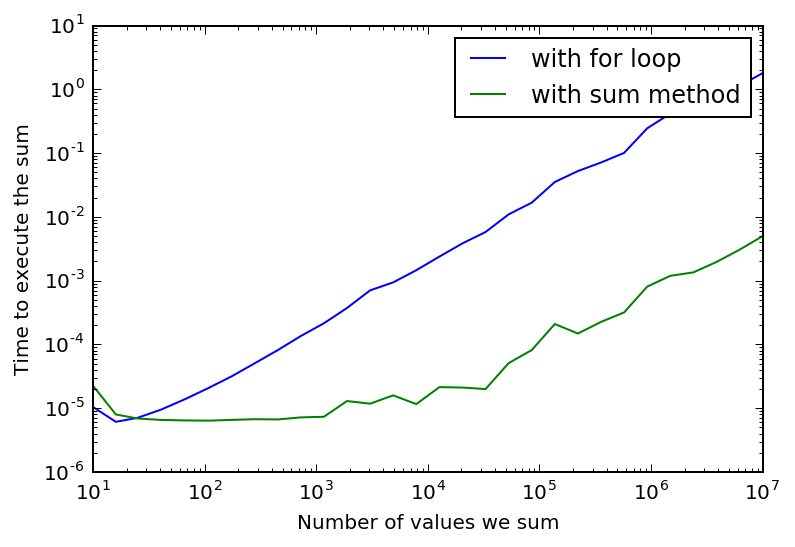

We can see that when the sum is getting larger the sum by for loop is less efficient (that is to say slower)
2.
For small numbers of values to sum the sum method is less efficient but arround 20 the for loop becomes slower.
The divide and conquer technique is good for large numbers as it really gain some time. For small numbers it is just more work and the for loop is better
Though we can argue that 20 is a not that big and we often have to sum more than 20 values.
3.


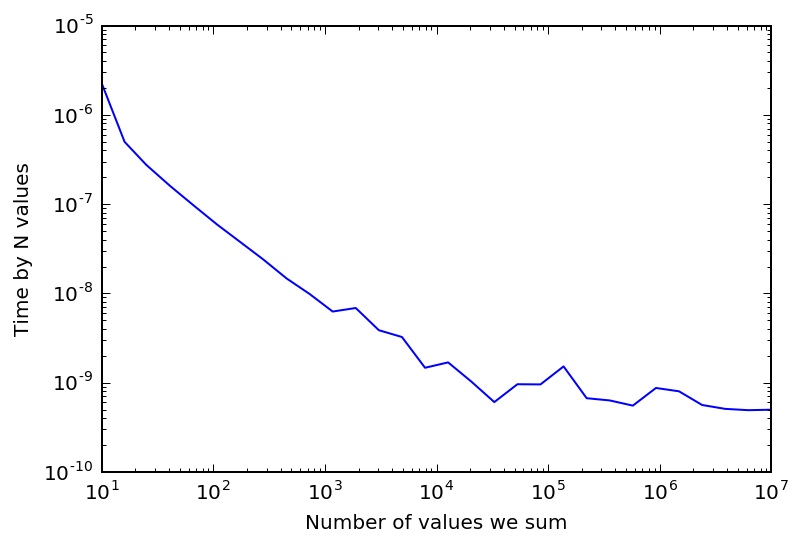

We can see that the time compared to the number of values decreases fastly, which confirms that the more value we have to sum the better it is to use the sum method


In [32]:
print("1.")
hugeList = np.random.random_sample((10000000,))

def mySum(array, n):
    s = 0
    for i in range(n):
        s += array[i]
    return s

def npSum(array, n):
    return np.sum(array[0:n])

valuesofN = (np.logspace(1, 7, 30)).astype(np.int64)
timesMySum = np.array([])
timesNpSum = np.array([])
timesNpByN = np.array([])

for j in valuesofN :
    tic = time.perf_counter()
    mySum(hugeList, j)
    time_passes = time.perf_counter() - tic
    timesMySum = np.append(timesMySum, time_passes)

    toc = time.perf_counter()
    npSum(hugeList, j)
    time_gone = time.perf_counter() - toc
    timesNpSum = np.append(timesNpSum, time_gone)
    timesNpByN = np.append(timesNpByN, time_gone/j)
    
plt.loglog(valuesofN, timesMySum, basex=10)
plt.loglog(valuesofN, timesNpSum, basex=10)
plt.xlabel("Number of values we sum")
plt.ylabel("Time to execute the sum")
plt.legend(["with for loop", "with sum method"])
plt.show()

print("We can see that when the sum is getting larger the sum by for loop is less efficient (that is to say slower)")
print("2.\nFor small numbers of values to sum the sum method is less efficient but arround 20 the for loop becomes slower.")
print("The divide and conquer technique is good for large numbers as it really gain some time. For small numbers it is just more work and the for loop is better")
print("Though we can argue that 20 is a not that big and we often have to sum more than 20 values.")

print("3.")
plt.loglog(valuesofN, timesNpByN, basex=10)
plt.xlabel("Number of values we sum")
plt.ylabel("Time by N values")
plt.show()
print("We can see that the time compared to the number of values decreases fastly, which confirms that the more value we have to sum the better it is to use the sum method")

## Hacker points (15 points)
-- --

Exercises designated as *hacker points* are undervalued problems that are completely optional (i.e. there is no need to do them to get full grades in this course). However, they will complement your experience and can be useful to offset points lost in other exercises. Partial answers don't count—hacker points are either awarded in full or not at all.

### Interval arithmetic

1. Use ``f2i`` and ``i2f`` to define a new function ``flt_next(value, dir)`` which takes a floating point value ``value`` and a direction ``dir`` (either ``-1`` or ``+1``) to move to the next smaller or larger floating point value, respectively. It should work for positive and negative normalized inputs, though it is fine to ignore special cases such as overflow to infinity, underflow to zero, etc.

  (For future reference: NumPy provides the function ``np.nextafter`` which does exactly this while accounting for all special cases, but here we'll use our own implementation for educational reasons.)<br><br>
  
2. Read up on the rules of interval arithmetic and extend the interval class template below with the methods ``__add__``, ``__sub__``, ``__neg__`` (unary negation), ``__mul__``, ``__truediv__`` (division with fractional result), and ``sqrt``. Since we unfortunately can't adjust the processor's rounding mode in Python, use the following workaround: after every arithmetic operation, use ``flt_next`` to conservatively move the lower and upper interval endpoints down and up by 1 ULP, respectively.<br><br>

3. Use the the finished interval arithmetic class to solve the previous quadratic equation using the "bad" algorithm from Problem 3 (in 16 bit arithmetic). Do the computed intervals bound the roots? How large are they?<br><br>

4. Suppose we aren't confident in the value of coefficient ``A``—however, we can with certainty say that $A\in[0.9, 1.1]$. Use interval arithmetic to determine how this uncertainty propagates to the computed solutions, and which of the two roots is more ambiguous (in absolute terms).

In [ ]:
class Interval:
    """ This class represents a real-valued interval [a, b]. It implements
        various elementary arithmetic operations, which produce intervals
        that bound the set of results which could be obtained by performing
        the same arithmetic operations with interval elements """
    
    def __init__(self, value, extra = None):
        """ Initialize the instance with the specified interval or constant """
        if type(value) is Interval:
            # Initialize with an interval instance
            self.x0, self.x1 = value.x0, value.x1
        else:
            # Initialize with a constant or an interval specified as 2 numbers
            self.x0 = np.array(value)
            self.x1 = np.array(value if extra is None else extra)
        self.dtype = self.x0.dtype
        
    def __repr__(self):
        """ Return a string representation of the interval """
        return "Interval[%f, %f]" % (self.x0, self.x1)
        
    def __add__(self, other):
        """ Add two intervals """
        # Ensure that the other argument is an Interval
        # (to permit addition of a constant to an interval)
        if type(other) is not Interval:
            other = Interval(other)
            
        # Hmm, this is probably not right
        return Interval(0, 1) 